In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xray
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm as basemap_cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date
import bottleneck as npb
# For temporary display of existing figures
from IPython.display import Image

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons
from rasmlib.analysis.io_tools import read_r_arctic_net_data

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'

# RASM run files used in this analysis
baseline_sim = 'R1009RBRceap01a'
rasm_sims = ['R1009RBRceap01a', 'R1009RBRceap01b', 'R1009RBRbslr01a', 'R1009RBbaaa01a']
ncfiles[baseline_sim] = '/raid2/jhamman/projects/RASM/data/processed/R1009RBRceap01a/lnd/monthly_mean_timeseries/R1009RBRceap01a.vic.hmm.197909-201412.nc'
ncfiles['R1009RBRceap01b'] = '/raid2/jhamman/projects/RASM/data/processed/R1009RBRceap01b/lnd/monthly_mean_timeseries/R1009RBRceap01b.vic.hmm.197909-200912.nc'
ncfiles['R1009RBRbslr01a'] = '/raid2/jhamman/projects/RASM/data/processed/R1009RBRbslr01a/lnd/monthly_mean_timeseries/R1009RBRbslr01a.vic.hmm.197909-199912.nc'
ncfiles['R1009RBbaaa01a'] = '/raid2/jhamman/projects/RASM/data/processed/R1009RBbaaa01a/lnd/monthly_mean_timeseries/R1009RBbaaa01a.vic.hmm.197909-200012.nc'

# Comparison datasets

# Spatio-temporal - monthly
ncfiles['era_monthly_ts1'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/wrf-197909-201212.era_i.nc'
ncfiles['era_monthly_ts2'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/met_em-197909-201212.nc'
ncfiles['era_monthly_ts3'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/era_water_vars.1979-2014.nc'
ncfiles['merra_monthly_ts1'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_lnd_Nx.197901-201312.SUB.wr50a.nc'
ncfiles['merra_monthly_ts2'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_rad_slv_Nx.1979-2015.SUB.wr50a.nc'
ncfiles['cru_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/cru_ts3.21/cru_ts3.21.1901.2012_wr50a.nc'
ncfiles['sheffield_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/sheffield2006/sheffield2006_wr50a.mm.nc'
ncfiles['adam_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/adam2003/adam2003_wr50a.mm.nc'
ncfiles['gfluxnet_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/GlobalFluxNet/GlobalFluxNet.wr50a.1982-2011.nc'
ncfiles['globalbedo_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/GlobAlbedo/GlobAlbedo.1998-2011.mosaic.wr50a.nc'

rarcticnet_monthly_ts_file = "/raid2/jhamman/projects/RASM/data/compare/r-arcticnet/Discharge_ms.csv"
rarcticnet_attrs_file = "/raid2/jhamman/projects/RASM/data/compare/r-arcticnet/SiteAttributes_filled_cleaned.csv"

start='1989-09-01'
end='2014-08-31'

In [4]:
rarcticnet_obs, rarcticnet_basin_area, rarcticnet_atts = read_r_arctic_net_data(rarcticnet_monthly_ts_file, rarcticnet_attrs_file)

In [5]:
ncdata = {}
for k, v in ncfiles.items():
    try:
        print(k)
        ncdata[k] = xray.open_dataset(v)
        if 'time' in ncdata[k]:
            sorts = np.argsort(ncdata[k].time.to_index().to_julian_date())
            if not all(sorts == np.arange(len(sorts))):
                ncdata[k].load()
                ncdata[k] = ncdata[k].isel(time=sorts)
    except:
        print(k, '<---unable to decode time!', )
        ncdata[k] = xray.open_dataset(v, decode_times=False)
ncdata['gfluxnet_monthly_ts']['time'] = pd.date_range('1982-01-01', '2011-12-01', freq='MS')

# Rename variables in datasets as necessary
name_dicts = {'era_monthly_ts1': {'rsus': 'Swup',
                                  'rsds': 'Swin',
                                  'rlus': 'Lwup',
                                  'rlds': 'Lwin',
                                  'hfss': 'Senht',
                                  'hfls': 'Latht',
                                  'snow_depth': 'Swq',
                                  'precip_tot': 'Precipitation',
                                  'LW_deac_net': 'Lwnet',
                                  'SW_deac_net': 'Swnet',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts2': {'T_2m': 'Tair',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts3': {'tp': 'Precipitation',
                                  'e': 'Evap',
                                  'ro': 'Runoff'},
              'sheffield_monthly_ts':{'tas': 'Tair',
                                      'prcp': 'Precipitation'},
              'merra_monthly_ts1': {'prectot': 'Precipitation',
                                    'runoff': 'Runoff',
                                    'baseflow': 'Baseflow',
                                    'shland': 'Senht',
                                    'lhland': 'Latht',
                                    'snomas': 'Swq',
                                    'evland': 'Evap',
                                    'lwland': 'Lwnet',
                                    'swland': 'Swnet'},
              'merra_monthly_ts2': {'lwgem': 'Lwup',
                                    'swgdn': 'Swin',
                                    'swgnt': 'Swnet',
                                    'lwgnt': 'Lwnet',
                                    't2m': 'Tair',
                                   },
              'cru_monthly_ts': {'tmp': 'Tair',
                                 'pre': 'Precipitation'},
              'adam_monthly_ts': {'Precip': 'Precipitation'},
              'gfluxnet_monthly_ts': {'EnsembleHcor_May12': 'Senht',
                                      'EnsembleLEcor_May12': 'Latht'},
              'globalbedo_monthly_ts': {'albedo': 'calc_albedo'}
              }

for k, v in ncdata.items():
    if k in name_dicts:
        print(k)
        v.rename(name_dicts[k], inplace=True)

cru_monthly_ts
R1009RBRceap01a
adam_monthly_ts
merra_monthly_ts1
gfluxnet_monthly_ts
gfluxnet_monthly_ts <---unable to decode time!
rasm_domain
era_monthly_ts3
era_monthly_ts2
sheffield_monthly_ts
era_monthly_ts1
R1009RBRceap01b
R1009RBRbslr01a
rasm_masks
R1009RBbaaa01a
globalbedo_monthly_ts
merra_monthly_ts2
cru_monthly_ts
adam_monthly_ts
merra_monthly_ts1
gfluxnet_monthly_ts
era_monthly_ts3
era_monthly_ts1
sheffield_monthly_ts
merra_monthly_ts2
globalbedo_monthly_ts
era_monthly_ts2


In [6]:
re = 6.37122e6
# Add variables or adjust units of datasets if ncessary

# RASM
ncdata['rasm_domain']['area'] *= re * re  # m2
for r in rasm_sims:
    ncdata[r]['calc_albedo'] = ncdata[r]['calc_albedo'] = 1 - (ncdata[r]['Swnet'] / ncdata[r]['Swin'])

    ncdata[r]['runoff_tot'] = ncdata[r]['Runoff'] + ncdata[r]['Baseflow']
    
# sheffield
ncdata['sheffield_monthly_ts']['Tair'] -= 273.15
ncdata['sheffield_monthly_ts']['Precipitation'] *= 86400 

# ERA-Interim
ncdata['era_monthly_ts1']['calc_albedo'] = ncdata['era_monthly_ts1']['Swup'] / ncdata['era_monthly_ts1']['Swin']
ncdata['era_monthly_ts1']['Swnet'] = ncdata['era_monthly_ts1']['Swin'] - ncdata['era_monthly_ts1']['Swup']
ncdata['era_monthly_ts1']['Lwnet'] = ncdata['era_monthly_ts1']['Lwin'] - ncdata['era_monthly_ts1']['Lwup']

for var in ('Runoff', 'Precipitation', 'Evap'):
    ncdata['era_monthly_ts3'][var] *= 1000.
ncdata['era_monthly_ts3'] = ncdata['era_monthly_ts3'].resample('MS', how='mean', dim='time')
ncdata['era_monthly_ts3']['runoff_tot'] = ncdata['era_monthly_ts3']['Runoff']

# MERRA
ncdata['merra_monthly_ts1']['Precipitation'] *= 86400 
ncdata['merra_monthly_ts1']['Runoff'] *= 86400 
ncdata['merra_monthly_ts1']['Baseflow'] *= 86400 
ncdata['merra_monthly_ts1']['Evap'] *= 86400 
ncdata['merra_monthly_ts1']['runoff_tot'] = ncdata['merra_monthly_ts1']['Runoff'] + ncdata['merra_monthly_ts1']['Baseflow']
ncdata['merra_monthly_ts2']['calc_albedo'] = 1 - (ncdata['merra_monthly_ts2']['Swnet'] / ncdata['merra_monthly_ts2']['Swin'])
# ncdata['merra_monthly_ts2']['Lwin'] = ncdata['merra_monthly_ts2']['Lwup'] + ncdata['merra_monthly_ts2']['Lwnet']
# ncdata['merra_monthly_ts2']['Swup'] = ncdata['merra_monthly_ts2']['Swin'] - ncdata['merra_monthly_ts2']['Swnet']
# ncdata['merra_monthly_ts2']['Radin'] = ncdata['merra_monthly_ts2']['Swin'] + ncdata['merra_monthly_ts2']['Lwin']
ncdata['merra_monthly_ts2']['Tair'] -= 273.15

# Global Fluxnet
ncdata['gfluxnet_monthly_ts']['Senht'] *= (1.0e6) / 86400.  # "MJoule*m-2*d-1" --> "W*m-2"
ncdata['gfluxnet_monthly_ts']['Latht'] *= (1.0e6) / 86400.  # "MJoule*m-2*d-1" --> "W*m-2"

In [7]:
for r in rasm_sims:
    ncdata[r]['time'] = pd.date_range(start='1979-09', freq='MS',
                                              periods=len(ncdata[r]['time']))

In [8]:
check_dict = {'gfluxnet_monthly_ts': ('Senht', 'Latht'),
              'merra_monthly_ts1': ('Precipitation', 'Evap', 'runoff_tot'),
              'merra_monthly_ts2': ('Tair', 'calc_albedo', 'Swnet', 'Lwnet'),
              'era_monthly_ts3': ('Precipitation', 'Evap', 'runoff_tot'),
              'era_monthly_ts2': ('Tair', ),
              'era_monthly_ts1': ('calc_albedo', 'Swnet', 'Lwnet'),
              'sheffield_monthly_ts': ('Tair', 'Precipitation'),
              'globalbedo_monthly_ts': ('calc_albedo', )}

# check which grid cells have nans in all grid cells for axis 0
infinite = np.zeros_like(ncdata['rasm_domain']['area'].values, dtype=bool)
for k, var_tup in check_dict.items():
    for v in var_tup:
        infinite += ~np.isfinite(ncdata[k][v].values).all(axis=0).squeeze()

analysis_mask = ~infinite * ncdata['rasm_masks']['mask_active_land'].values > 0.9

In [9]:
def get_start_end_inds(index, start=None, end=None):
    si = None
    ei = None
    if start is not None:
        si = np.nonzero(index == start)[0][0]
    if end is not None:
        ei = np.nonzero(index == end)[0][0]
        
    return si, ei

In [10]:
# Make the plot
def plot_by_mask(datasets, masks, variables, ylabels=None, figsize=(11, 8.5), colors=None, diff_key=None, sum_func=npb.nansum):
    """
    datasets : OrderedDict of xray.Datasets
        dict of datasets with 
    masks : OrderedDict of numpy.NDArrays
        dict of 2d masks, keys in dictionary are used as titles
    rows : list like
        list of variable names to include in plot
    ylabels : list like, same size as rows
        list of ylabels (variable names) for plot
    figsize : tuple
        figure size, passed to pyplot.subplots
    """
    
    if ylabels is None:
        ylabels = variables
    
    fig, axes = plt.subplots(nrows=len(variables), ncols=len(masks), figsize=figsize, sharex=True, sharey='row')

    for i, (title, mask) in enumerate(masks.items()):

        ys, xs = np.nonzero(mask)
        areas = ncdata['rasm_domain']['area'].values[ys, xs]
        weights = (mask[ys, xs] * areas)
        weights /= weights.sum()

        for j, var in enumerate(variables):
            ax = axes[j, i]
            plt.sca(ax)
            ax.set_xlim((1, 12))
            

            if diff_key is not None:
                compare = sum_func(np.squeeze(datasets[diff_key][var].values)[:, ys, xs] * weights, axis=1)
            
            for name, ds in datasets.items():
                if var in ds:
                    
                    data = sum_func(np.squeeze(ds[var].values)[:, ys, xs] * weights, axis=1)
                    if diff_key is not None:
                        data -= compare
                    
                    if var == 'calc_albedo':
                        data[0] = np.nan
                        data[11:] = np.nan
                        print('Warning, Albedo cludge still in place')
                    
                    ax.plot(months, data, color=colors[name])

            if i == 0:
                ax.set_ylabel(ylabels[j])
            if j == 0:
                ax.set_title(title)

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)

    # add legend
    lines = []
    labels = []
    for source, color in colors.items():
        lines.append(mlines.Line2D([], [], color=color, label=var, linewidth=3))
        labels.append(source)
  
    leg = fig.legend(handles=lines, labels=labels, ncol=6, columnspacing=6,
                     fontsize=10, bbox_to_anchor=[0.52, 0.08], loc='upper center',
                     borderaxespad=0.05)
    leg.draw_frame(True)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(0.5)
    
    return fig, axes
    
#     plt.tight_layout(h_pad=0, w_pad=0)


In [13]:
e_datasets = OrderedDict()
e_datasets['ERA'] = ncdata['era_monthly_ts1'][['calc_albedo', 'Swnet', 'Lwnet', 'Latht', 'Senht']].sel(time=slice(start, end)).groupby('time.month').mean('time')
e_datasets['ERA']['Tair'] = ncdata['era_monthly_ts2']['Tair'].sel(time=slice(start, end)).groupby('time.month').mean('time')
e_datasets['MERRA'] = ncdata['merra_monthly_ts1'][['Swnet', 'Lwnet', 'Latht', 'Senht']].sel(time=slice(start, end)).groupby('time.month').mean('time')
e_datasets['MERRA']['calc_albedo'] = ncdata['merra_monthly_ts2']['calc_albedo'].sel(time=slice(start, end)).groupby('time.month').mean('time')
e_datasets['MERRA']['Tair'] = ncdata['merra_monthly_ts2']['Tair'].sel(time=slice(start, end)).groupby('time.month').mean('time')

e_datasets['GLOBALBEDO'] = ncdata['globalbedo_monthly_ts'].sel(time=slice(start, end)).groupby('time.month').mean('time')
e_datasets['J2011'] = ncdata['gfluxnet_monthly_ts'][['Latht', 'Senht']].sel(time=slice(start, end)).groupby('time.month').mean('time')

for case in rasm_sims:
    e_datasets[case] = ncdata[case][['Tair', 'calc_albedo', 'Swnet', 'Lwnet', 'Latht', 'Senht']].sel(time=slice(start, end)).groupby('time.month').mean('time')

In [14]:
masks = OrderedDict()
mask_keys = ['mask_tundra', 'mask_boreal_forests_taiga', 'mask_temperate_broadleaf_and_mixed_forests',
             'mask_temperate_grasslands_savannas_and_shrublands', 'mask_temperate_coniferous_forests']
titles = ['Tundra', 'Taiga', 'Temperate\nBroadleaf\nForests',
          'Temperate\nGrasslands', 'Temperate\nConiferous\nForests']
mask_keys = ['mask_tundra', 'mask_boreal_forests_taiga', 'mask_lena', 'mask_rvic_drainage']
titles = ['Tundra', 'Taiga', 'Lena River', 'RVIC Drainage']
for name, key in zip(titles, mask_keys):
    masks[name] = ncdata['rasm_masks'][key].values * analysis_mask

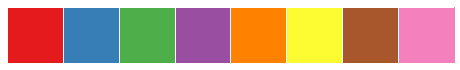

In [15]:
variables = ['Tair', 'calc_albedo', 'Swnet', 'Lwnet', 'Latht', 'Senht']
ylabels = ['Tair ($^\circ C$)', 'Albedo (-)', 'SWnet ($W/m^2$)', 'LWnet ($W/m^2$)', 'LE ($W/m^2$)', 'H ($W/m^2$)']

months = np.arange(1, 13, 1)

current_palette = sns.color_palette(n_colors=len(e_datasets), palette='Set1')
sns.palplot(current_palette)
colors = OrderedDict()
for i, name in enumerate(e_datasets):
    colors[name] = current_palette[i]
    
colors[baseline_sim] = (0, 0, 0)


Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Alb

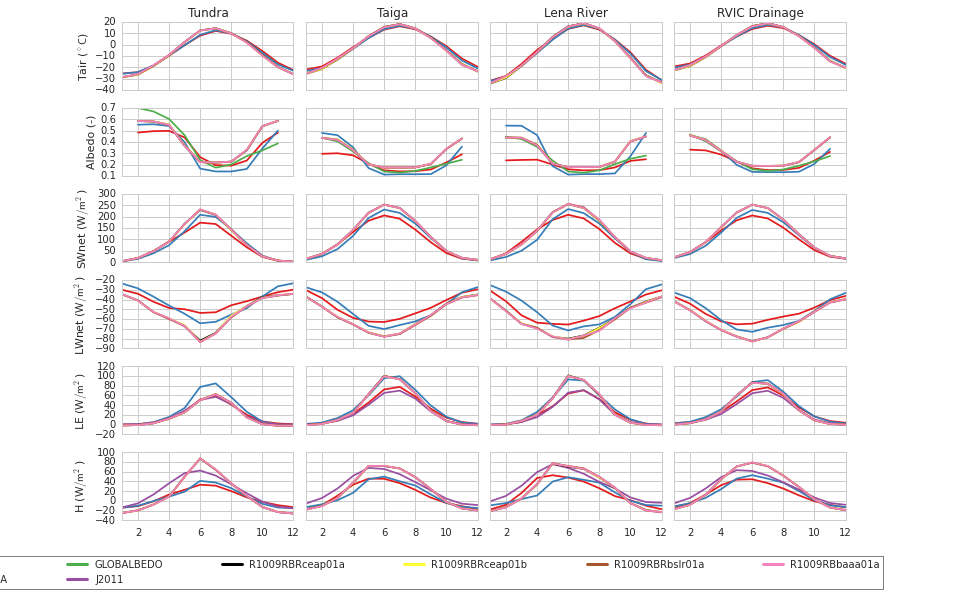

In [16]:
sns.set_style("whitegrid")
fig, axes = plot_by_mask(e_datasets, masks, variables, ylabels=ylabels, colors=colors, sum_func=np.sum)
# fig.savefig('rasm1_annual_cycle_energy.pdf', dpi=dpi, bbox_inches='tight')
# fig.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_03.pdf'), dpi=dpi, bbox_inches='tight')

Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Albedo cludge still in place
Warning, Alb

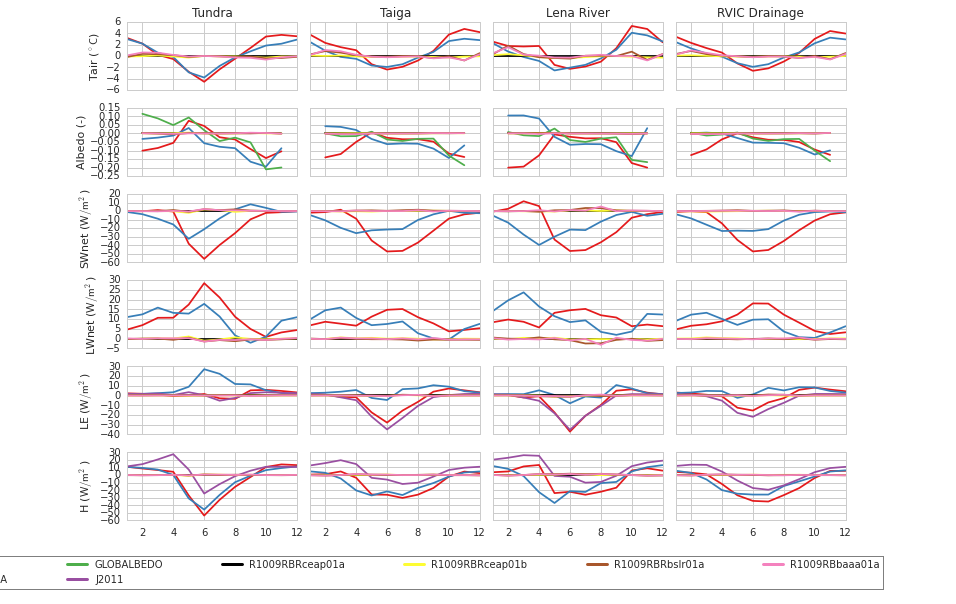

In [17]:
diff_datasets = e_datasets.copy()
diff_datasets[baseline_sim] = ncdata[baseline_sim][['Tair', 'calc_albedo', 'Swnet', 'Lwnet', 'Latht', 'Senht']].sel(time=slice(start, end)).groupby('time.month').mean('time')
diff_colors = colors.copy()
fig, axes = plot_by_mask(diff_datasets, masks, variables, ylabels=ylabels, colors=diff_colors, sum_func=np.sum, diff_key=baseline_sim)
# fig.savefig('rasm1_annual_cycle_energy_diff.pdf', dpi=dpi, bbox_inches='tight')
# fig.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_08.pdf'), dpi=dpi, bbox_inches='tight')

In [18]:
w_datasets = OrderedDict()
w_datasets['ERA'] = ncdata['era_monthly_ts1'][['Swq', 'calc_albedo']].sel(time=slice(start, end)).groupby('time.month').mean('time')
w_datasets['ERA']['Tair'] = ncdata['era_monthly_ts2']['Tair'].sel(time=slice(start, end)).groupby('time.month').mean('time')
w_datasets['ERA']['Precipitation'] = ncdata['era_monthly_ts3']['Precipitation'].sel(time=slice(start, end)).groupby('time.month').mean('time')
w_datasets['ERA']['runoff_tot'] = ncdata['era_monthly_ts3']['runoff_tot'].sel(time=slice(start, end)).groupby('time.month').mean('time')
w_datasets['ERA']['Evap'] = -1 * ncdata['era_monthly_ts3']['Evap'].sel(time=slice(start, end)).groupby('time.month').mean('time')
w_datasets['MERRA'] = ncdata['merra_monthly_ts1'][['Precipitation', 'runoff_tot', 'Evap', 'Swq']].sel(time=slice(start, end)).groupby('time.month').mean('time')
e_datasets['MERRA']['Tair'] = ncdata['merra_monthly_ts2']['Tair'].sel(time=slice(start, end)).groupby('time.month').mean('time')
w_datasets['A2006'] = ncdata['adam_monthly_ts'][['Precipitation']].sel(time=slice(start, end)).groupby('time.month').mean('time')

for case in rasm_sims:
    w_datasets[case] = ncdata[case][['Tair', 'Precipitation', 'runoff_tot', 'Evap', 'Swq']].sel(time=slice(start, end)).groupby('time.month').mean('time')


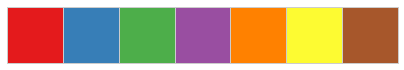

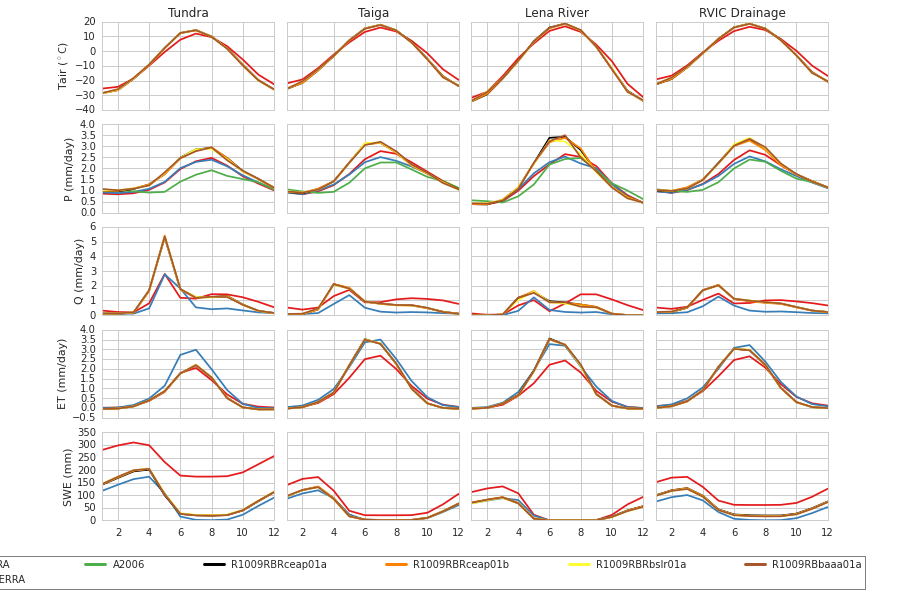

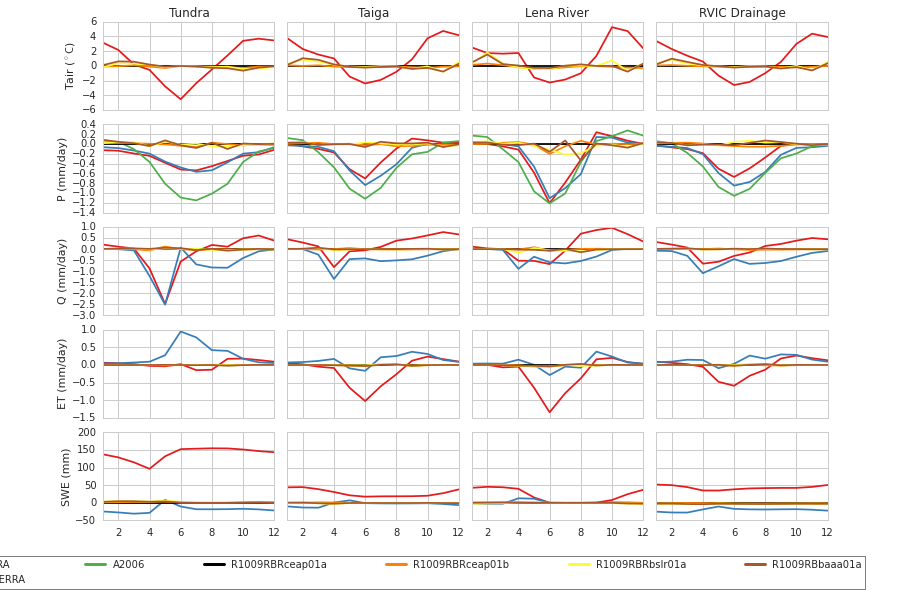

In [19]:

variables = ['Tair', 'Precipitation', 'runoff_tot', 'Evap', 'Swq']
ylabels = ['Tair ($^\circ C$)', 'P (mm/day)', 'Q (mm/day)', 'ET (mm/day)', 'SWE (mm)']

months = np.arange(1, 13, 1)

current_palette = sns.color_palette(n_colors=len(w_datasets), palette='Set1')
sns.palplot(current_palette)
colors = OrderedDict()
for i, name in enumerate(w_datasets):
    colors[name] = current_palette[i]
    
colors[baseline_sim] = (0, 0, 0)

sns.set_style("whitegrid")
fig, axes = plot_by_mask(w_datasets, masks, variables, ylabels=ylabels, colors=colors)
# fig.savefig('rasm1_annual_cycle_water_norof.pdf', dpi=dpi, bbox_inches='tight')


fig, axes = plot_by_mask(w_datasets, masks, variables, ylabels=ylabels, colors=colors, diff_key=baseline_sim)
# fig.savefig('rasm1_annual_cycle_water_norof_diff.pdf', dpi=dpi, bbox_inches='tight')
# fig.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_09.pdf'), dpi=dpi, bbox_inches='tight')


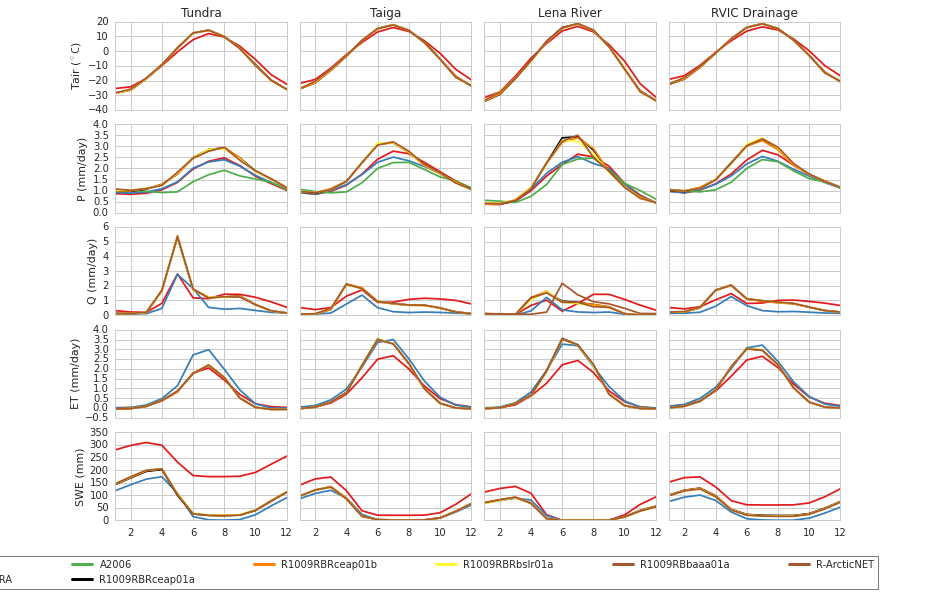

In [20]:
colors['R-ArcticNET'] = current_palette[-1]
fig, axes = plot_by_mask(w_datasets, masks, variables, ylabels=ylabels, colors=colors)

closest_guages = {'mask_yukon': b'YUKON_R_AT_PILOT_STATION_AK',
                  'mask_lena': b'Lena_At_Stolb',
                  'mask_ob': b'Ob_At_Salekhard',
                  'mask_mackenzie': b'MACKENZIE_RIVER_AT_ARCTIC_RED_RIVER'}

for i, key in enumerate(mask_keys):
    try:
        rarcticnet_obs[closest_guages[key]].groupby(lambda x: x.month).mean().plot(color=colors['R-ArcticNET'], ax=axes[2, i]) # style='--', linewidth=4, 
    except KeyError:
        pass
# fig.savefig('rasm1_annual_cycle_water.pdf', dpi=dpi, bbox_inches='tight')
# fig.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_07.pdf'), dpi=dpi, bbox_inches='tight')